# Historical temperature trend and biases from CMIP6 models

## Abstract

This notebook code computes and displays temperature trend and related bias for a, randomly selected, subset of [CMIP6](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections) global climate models (GCMs). The code aims to explore the capability of individual models and their ensemble mean as well as to reproduce the mean annual/seasonal trends during a historical period (1971-2005). Biases are derived by comapring simulated trends to those from ECMWF reanalysis [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-complete?tab=doc). 

GCMs are the primary tools for investigating the response of the climate system to various forcing, and for making climate predictions from seasonal to the coming century, and beyond, time scales. The objective of the CMIP6 initiative is to better understand past, present, and future climate change arising from natural, unforced variability or in response to changes in radiative forcing by means of a multi-model comparison. This latter is the key aspect to associate a level of uncertainty to any type of climate information you might enquiry climate models. Each model has its response (i.e., sensitivity) to the same forcing and subsequently, this defines a spectrum of plausible outcomes.

This notebook presents results for temperature trend. The size and location of the subdomain considered are customizable, as well as the temporal aggregation (annual or seasonal). User can decide to mask or not ocean grid points.

## Analyses 

This notebook performs the following analyses:
- historical spatially-averaged time series from a climate models ensemble and ERA5;
- boxplots representing historical trend distribution of climate models.
- trend maps, represent the spatial distribution of GCMs and ERA5 historical trends. 
- trend bias maps.
- statistical distribution of trend bias. PDFs (probability density functions) are built considering grid node-by-grid node trend bias from each GCM and ensemble mean.
- [Taylor diagram](http://dx.doi.org/10.1029/2000JD900719) providing a statistical summary of how well GCMs reproduce trend spatial pattern.


## Import packages

In [31]:
import functools

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skill_metrics
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from xarrayMannKendall import Mann_Kendall_test

plt.style.use("seaborn-v0_8-notebook")
plt.rcParams["hatch.linewidth"] = 0.5

## Define Parameters

In the "Define Parameters" section the customizable options of the notebook are set. These parameters consist of:
- the initial and ending year of the climatological analyses ('year_start' and 'year_stop').
- In the 'time series' parameter, we can set the temporal aggregation of climate data, in this case "annual" meaning that the entire year is considered instead of individual seasons.
- The 'Variable' parameter selects the variable to process. Temperature and precipitation available.
- 'collection_id' selects the climate simulations dataset consisting of a representative sub-set of the GCMs ensemble from CMIP6 and a sub-set of RCMs from the CORDEX initiative.
- For both types of climate models, we can choose to analyse a subdomain whose borders are selected by 'lon_slice' and 'lat_slice' parameters.
- Only for CORDEX simulations we can specify the different domains (e.g., europe, africa, north_america etc.) available through 'cordex_domain'. The selection of a region of analysis should be subsequently included within the CORDEX domain selected.
- 'chunk' selection allows to set the time length of data downloading and chunking in your local machine. It has not really effect on the analysis performed, so we suggest to keep the default value. 

In [32]:
# Choose annual or seasonal timeseries
timeseries = "annual"
assert timeseries in ("annual", "DJF", "MAM", "JJA", "SON")

# Variable
variable = "temperature"
assert variable in ("precipitation", "temperature")

# Choose CORDEX or CMIP6
collection_id = "CMIP6"
assert collection_id in ("CORDEX", "CMIP6")

# Define region for analysis
lon_slice = slice(-180, 180)
lat_slice = slice(-90, 90)

# Define region for request
cordex_domain = "europe"

# Mask out sea grid nodes
mask_sea = True
assert isinstance(mask_sea, bool)

# Chunks for download
chunks = {"year": 1}
assert "month" not in chunks, "Do not use chunks smaller than 1y"

In [33]:
if collection_id == "CMIP6":
    # Time period
    year_start = 1950
    year_stop = 2014
    
    # Climatology period
    clima_year_start = 1950
    clima_year_stop = 1970
elif collection_id == "CORDEX":
    # Time period
    year_start = 1971
    year_stop = 2005
    
    # Climatology period
    clima_year_start = 1971
    clima_year_stop = 1980
    

## Define models

The following climate analyses are performed considering a representative sub-set of RCMs from CORDEX and GCMs from CMIP6. Models names are listed in the parameters below. 

CMIP6 models can be chosen independently from the definition of parameters made in the cell above. To facilitate data download and processing, this notebook make use of CMIP6 models with coarse horizontal resolution. 

Cordex models selection has to accurately take into consideration the availability of RCMs for the selected GCM and the selected region. RCMs listed here are available for GCM “mpi_m_mpi_esm_lr” in the “europe” cordex_domain. Available combinations can be checked at confluence cordex webpage.

In [34]:
models_cordex = [
    "clmcom_clm_cclm4_8_17",
    "clmcom_eth_cosmo_crclim",
    "cnrm_aladin63",
    "dmi_hirham5",
    "knmi_racmo22e",
    "mohc_hadrem3_ga7_05",
    "mpi_csc_remo2009",
    "smhi_rca4",
    "uhoh_wrf361h",
]

models_cmip6 = [
    "cmcc_cm2_hr4",
    "mpi_esm1_2_lr",
    "access_cm2",
    "awi_esm_1_1_lr",
    "bcc_esm1",
    "cesm2_fv2",
    "cnrm_cm6_1",
    "fgoals_g3",
]

## Construct data request: ERA5

In this notebook, ERA5 is considered a reference product. In this section, we set the required parameters for the cds-api data-request of ERA5. 

In [35]:
era5_variables = {
    "precipitation": "mean_total_precipitation_rate",
    "temperature": "2m_temperature",
}

request_era = (
    "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "format": "netcdf",
        "time": "00:00",
        "variable": era5_variables[variable],
        "year": [
            str(year)
            for year in range(
                min(year_start, clima_year_start) - 1,  # Include D(year-1)
                max(year_stop, clima_year_stop) + 1,
            )
        ],
        "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    },
)

request_lsm = (
    request_era[0],
    request_era[1] | {"year": "1940", "month": "01", "variable": "land_sea_mask"},
)

## Construct data request: climate models

In this section we set the required parameters for the cds-api data-request. 

The function “get_cordex_years” is used to select appropriate chunks for the data request of CORDEX data. 
Weights = True implies spatial weighting of data for calculations that require spatial aggregation of data. CMIP6 GCMs have regular lon-lat grids which do not take into account the different surface extensions of the model grid cells at different latitudes, weighting is needed (Weights = True). CORDEX RCMs adopt rotated grids which take into account different cell surfaces as a function of the latitude not requiring a multiplicative factor of latitude cosine as the regular grid (Weights = False).

In [36]:
cordex_variables = {
    "precipitation": "mean_precipitation_flux",
    "temperature": "2m_air_temperature",
}

request_cordex = {
    "format": "zip",
    "domain": cordex_domain,
    "experiment": "historical",
    "horizontal_resolution": "0_11_degree_x_0_11_degree",
    "temporal_resolution": "monthly_mean",
    "variable": cordex_variables[variable],
    "gcm_model": "mpi_m_mpi_esm_lr",
    "ensemble_member": "r1i1p1",
}

cmip6_variables = {
    "precipitation": "precipitation",
    "temperature": "near_surface_air_temperature",
}
request_cmip6 = {
    "format": "zip",
    "temporal_resolution": "monthly",
    "experiment": "historical",
    "variable": cmip6_variables[variable],
    "year": request_era[1]["year"],
    "month": request_era[1]["month"],
}


def get_cordex_years(
    year_start,
    year_stop,
    start_years=[1971, 1981, 1991, 2001],
    end_years=[1980, 1990, 2000, 2005],
):
    start_year = []
    end_year = []
    years = set(range(year_start - 1, year_stop + 1))  # Include D(year-1)
    for start, end in zip(start_years, end_years):
        if years & set(range(start, end + 1)):
            start_year.append(start)
            end_year.append(end)
    return start_year, end_year


if collection_id == "CORDEX":
    weights = False  # Do not weight spatial statistics/errors
    periodic = False
    models = models_cordex
    model_key = "rcm_model"
    request_sim = (
        "projections-cordex-domains-single-levels",
        [
            {
                **request_cordex,
                "start_year": start_year,
                "end_year": end_year,
            }
            for start_year, end_year in zip(
                *get_cordex_years(
                    min(year_start, clima_year_start), max(year_stop, clima_year_stop)
                )
            )
        ],
    )
elif collection_id == "CMIP6":
    weights = True  # Weight spatial statistics/errors
    periodic = True
    models = models_cmip6
    model_key = "model"
    request_sim = (
        "projections-cmip6",
        download.split_request(request_cmip6, chunks=chunks),
    )
else:
    raise ValueError

## Functions to cache

In this notebook section are defined functions that will be executed in the caching phase.
Caching is the process of storing copies of files in a temporary storage location, so that they can be accessed more quickly. This procedure also recognises if a requested file have been already downloaded by the user, so that it is not necessary to perform the download again.

In this notebook the Mann-Kendall test is used for the calculation of trends. We call the function functools.partial(Mann_Kendall_test) for this purpose, renamed original_test().

The function “get_timeseries” aggregate data from monthly to annual resolution and convert units. Attribute timeseries, set in Define parameter section, states if the analysis should be done on annual (‘annual’) or seasonal ( "DJF", "MAM", "JJA", "SON") values. Function "compute_climatology" computes the time mean of the input dataset. Function "compute_anomaly" computes,for each timestep, the difference between dataset and its climatology. Function "spatial_weighted_trends computes first the timeseries of the spatial averaged values, then the correspondent anomalies and finally apply the Mann Kendall to obtain trend values with the associated significance. Function "regridded_trends" calculates, for each grid point, the trend of the timeseries with the associated significance.


In [37]:
original_test = functools.partial(Mann_Kendall_test, alpha=0.05, method="theilslopes")


def get_timeseries(ds, year_start, year_stop, timeseries):
    # Drop useless data
    if timeseries == "annual":
        mask = (ds["time"].dt.year >= year_start) & (ds["time"].dt.year <= year_stop)
    else:
        # Select years (shift -1 to get D(year-1)J(year)F(year))
        ds = ds.assign_coords(year=ds["time"].dt.year.shift(time=-1))
        mask = (
            (ds["year"] >= year_start)
            & (ds["year"] <= year_stop)
            & (ds["time"].dt.season == timeseries)
        )
    ds = ds.where(mask.compute(), drop=True)

    if var_names := set(ds.data_vars) & {"mtpr", "pr"}:
        field = "precipitation"
    elif var_names := set(ds.data_vars) & {"tas", "t2m"}:
        field = "temperature"
    else:
        raise ValueError("Unable to find precipitation or temperature variable.")
    (var_name,) = var_names
    da = ds[var_name].rename(field)

    # Create timeseries
    if timeseries == "annual":
        da = diagnostics.annual_weighted_mean(da)
    else:
        da["year"] = da["year"].astype(int)
        da = (
            da.groupby("year")
            .map(diagnostics.seasonal_weighted_mean)
            .sel(season=timeseries)
        )

    # Convert units
    with xr.set_options(keep_attrs=True):
        if da.name == "precipitation":
            da *= 3600 * 24
            da.attrs["units"] = "mm/day"
        elif da.name == "temperature":
            da -= 273.15
            da.attrs["units"] = "°C"
            da = da.assign_coords(height=ds["height"] if "height" in ds else None)
        else:
            raise ValueError
    return da


def compute_climatology(da, clima_year_start, clima_year_stop):
    return da.sel(year=slice(clima_year_start, clima_year_stop)).mean(
        "year", keep_attrs=True
    )


def compute_anomaly(da, clima_year_start, clima_year_stop):
    clima = compute_climatology(da, clima_year_start, clima_year_stop)
    anoma = da - clima
    units = da.attrs["units"]
    if da.name == "precipitation":
        anoma *= 100 / da
        units = "%"
    anoma.attrs.update({"long_name": f"{da.name} anomaly", "units": units})
    return anoma


def spatial_weighted_trends(
    obj,
    year_start,
    year_stop,
    clima_year_start,
    clima_year_stop,
    timeseries,
    weights,
    lon_slice,
    lat_slice,
    request_lsm,
):
    if isinstance(obj, xr.DataArray):
        da = obj
    else:
        ds = utils.regionalise(obj, lon_slice=lon_slice, lat_slice=lat_slice)
        if request_lsm:
            ds_lsm = download.download_and_transform(*request_lsm)
            da_lsm = ds_lsm["lsm"].squeeze("time", drop=True)
            da_lsm = diagnostics.regrid(
                da_lsm, ds[["longitude", "latitude"]], method="bilinear"
            )
            ds = ds.where(da_lsm > 0.5)

        da = diagnostics.spatial_weighted_mean(
            get_timeseries(ds, year_start, year_stop, timeseries), weights=weights
        )
    anoma = compute_anomaly(da, clima_year_start, clima_year_stop)

    # Compute anomaly trends
    ds = (
        original_test(
            anoma.expand_dims("x"),
            coords_name={"time": "year", "x": "x"},
        )
        .compute()
        .squeeze("x", drop=True)
    )

    # Add variable and anomaly
    return ds.merge({da.name: da, f"{da.name}_anomaly": anoma})


def regridded_trends(
    ds,
    year_start,
    year_stop,
    clima_year_start,
    clima_year_stop,
    timeseries,
    grid_out=None,
    **kwargs,
):
    da = get_timeseries(ds, year_start, year_stop, timeseries)

    # Compute anomaly trends
    coords_name = {"time": "year"} | {
        k: v for k, v in zip(("x", "y"), ds[["longitude", "latitude"]].dims)
    }
    ds_trend = original_test(da, coords_name=coords_name).compute()
    ds_trend = ds_trend.rename({k: v for k, v in coords_name.items() if k != "time"})
    ds_trend = ds_trend.assign_coords(ds.drop_dims("time").coords)

    # Add variable and climatology
    clima = compute_climatology(da, clima_year_start, clima_year_stop)
    ds_trend[f"{da.name}_climatology"] = clima
    if grid_out is not None:
        ds_trend = ds_trend.cf.add_bounds(
            coord
            for coord in ("longitude", "latitude")
            if coord not in ds_trend.cf.bounds
        )
        ds_trend = diagnostics.regrid(ds_trend, grid_out, **kwargs)
    return ds_trend

## Download data and compute spatial mean trends

This section downloads model and reference data, calculates the trends of the spatial averaged values through the transform function “spatial_weighted_trends”, and cache the results.

The output of this section, ds_mean_trend, contains the timeseries of the spatial averaged values, the timeseries of anomalies, the trend value and the associated significance. ds_mean_trend include such data for all the models, the correspondent ensemble mean and the reference dataset.

In [38]:
datasets = []
transform_func_kwargs = {
    "year_start": year_start,
    "year_stop": year_stop,
    "clima_year_start": clima_year_start,
    "clima_year_stop": clima_year_stop,
    "lon_slice": lon_slice,
    "lat_slice": lat_slice,
    "timeseries": timeseries,
    "request_lsm": request_lsm if mask_sea else None,
}
for model in models + ["ERA5"]:
    print(f"Downloading and processing {model}")
    if model == "ERA5":
        request_model = request_era
    else:
        request_model = request_sim
        for request in request_model[1]:
            request[model_key] = model
    ds = download.download_and_transform(
        *request_model,
        chunks=chunks if model == "ERA5" else {},
        transform_func=spatial_weighted_trends,
        transform_func_kwargs={
            "weights": True if model == "ERA5" else weights,
            **transform_func_kwargs,
        },
        transform_chunks=False,
    )
    datasets.append(ds.expand_dims(model=[model]))

# Combine and add ensemble
ds_mean_trend = xr.concat(datasets, "model")
da_ensemble = (
    ds_mean_trend[variable].drop_sel(model="ERA5").mean("model", keep_attrs=True)
)
ds_ensemble_trend = spatial_weighted_trends(
    da_ensemble, weights=weights, **transform_func_kwargs
)
ensemble_name = f"{collection_id} ensemble"
ds_mean_trend = ds_mean_trend.merge(
    ds_ensemble_trend.expand_dims(model=[ensemble_name])
)

## Results

## Plot timeseries

This section compares climate model timeseries with ERA5 timeseries. First panel show physical values, second panel show the associated anomalies with respect to 1971-1980 average. Absolute anomalies are given for temperature, percentage anomalies for precipitation.

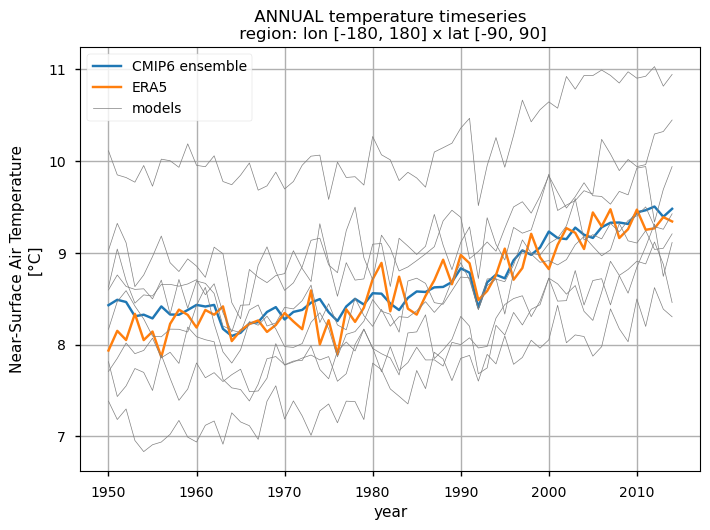

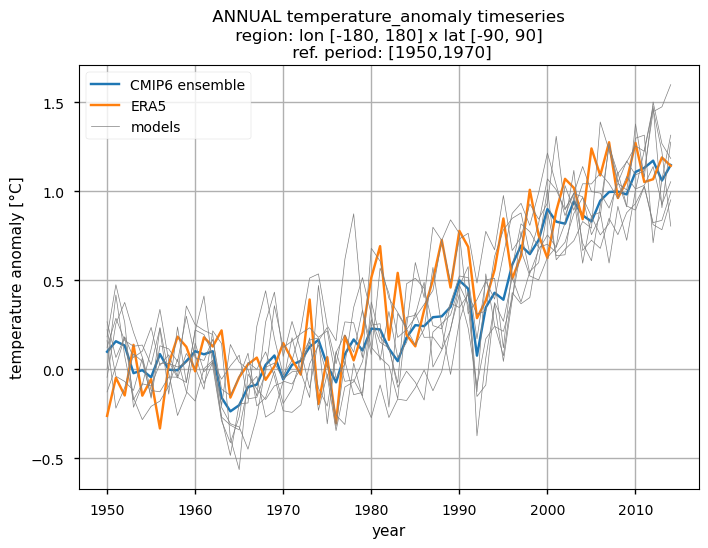

In [39]:
for var in [variable, f"{variable}_anomaly"]:
    fig, ax = plt.subplots(1, 1)
    da = ds_mean_trend[var]
    colored_models = [ensemble_name, "ERA5"]
    da_colored = ds_mean_trend[var].sel(model=colored_models)
    da_grey = ds_mean_trend[var].drop_sel(model=colored_models)
    da_colored.plot(hue="model", ax=ax, add_legend=False)
    da_grey.plot(hue="model", linewidth=0.5, color="grey", ax=ax, add_legend=False)
    if var == variable:
        ax.set_title(f" {timeseries.upper()} {var} timeseries \n region: lon [{lon_slice.start}, {lon_slice.stop}] x lat [{lat_slice.start}, {lat_slice.stop}]") #
    else:
        ax.set_title(f" {timeseries.upper()} {var} timeseries \n region: lon [{lon_slice.start}, {lon_slice.stop}] x lat [{lat_slice.start}, {lat_slice.stop}] \n ref. period: [{clima_year_start},{clima_year_stop}]") #
    ax.grid()
    ax.legend(colored_models + ["models"])

Fig. 1 CMIP6 historical and ERA5 annual mean time series. Grey lines represent individual model simulations, whereas in blue is represented the time series of the corresponding ensemble mean. The upper panel shows physical values, the bottom panel shows the same but in terms of anomalies (derived subtracting 1971-1980 period mean to the annual mean value) 

## Trends boxplot

This section compares model temperature or precipitation trends with the reference one (ERA5).

Dots represent the spatially-averaged historical trend over the selected region (°C of variation every 10 years) calculated for each model (grey),the ensemble mean (blue) and the reference product (orange).

The boxplot graphically depicts the trend distribution of the climate models through their quartiles.  The box extends from the first quartile (Q1 = 25 percentile) to the third quartile (Q3 = 75 percentile), with a green line at the median (Q2 = 50 percentile). Whiskers extend from the edges of box to show the range of the data. Whiskers extend up to 1.5 the  IQR, with IQR being the interquantile range, IQR = Q3 - Q1. Read [Pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html) for more info
.

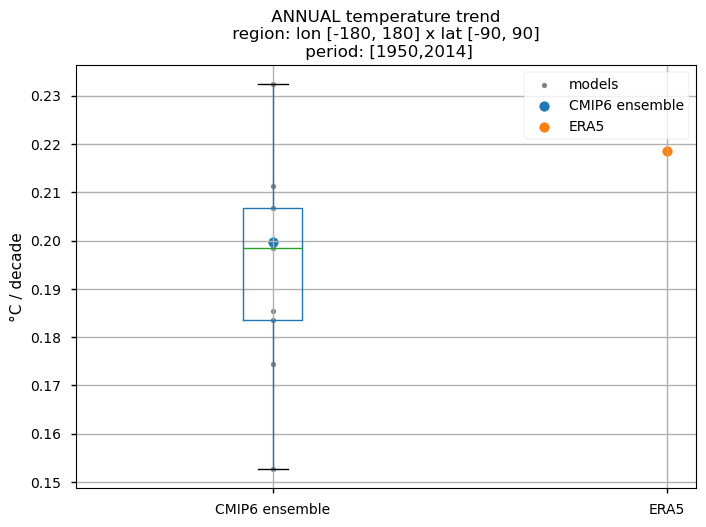

In [40]:
df_slope = (ds_mean_trend["trend"] * 10).to_dataframe()[["trend"]]
ax = df_slope[df_slope.index != "ERA5"].boxplot(showfliers=False)

df_slope_grey = df_slope[~df_slope.index.isin(colored_models)]
ax.scatter(
    x=[1] * len(df_slope_grey),
    y=df_slope_grey,
    color="grey",
    marker=".",
    label="models",
)
for x, model in enumerate(colored_models):
    ax.scatter(x=x + 1, y=df_slope[df_slope.index == model], label=model, marker="o")
units = ds_mean_trend[f"{variable}_anomaly"].attrs["units"] + " / decade"
ax.set_ylabel(units)
ax.set_title(f' {timeseries.upper()} {variable} trend \n region: lon [{lon_slice.start}, {lon_slice.stop}] x lat [{lat_slice.start}, {lat_slice.stop}] \n period: [{year_start},{year_stop}]' ) # 
ax.set_xticks(range(1, len(colored_models) + 1), colored_models)
_ = ax.legend()

Fig. 2 Historical annual means trend boxplots for models and reference ERA5. The distribution is built considering spatially averaged models trends over the subdomain of interest. Ensemble mean trend is also included. Grey circle with a black contour represents an outlier of the distribution 

## Download data and compute trend maps

This section downloads model and reference data and calculates, for each grid point, the historical trend of the selected variable (temperature or precipitation) using the function “spatial_weighted_trends”, and cache the results.

Calculation of trend and caching of the results are performed globally, that's why it can take quite long to run this cell. The regionalization is made in a second step, using the function utils.regionalise. Once this cell has been run, the trend results are cached for all the globe, so it is much faster to run it again and produce trend maps for any region of interest.

First output of this section, da_trend, contains maps of historical trend value and the associated significance, together with the climatological mean. da_trend includes such data for all the models, the correspondent ensemble mean and the reference dataset.

Second output, da_bias, contains the bias values with respect to the reference dataset.

In [41]:
print("Downloading and processing ERA5")
transform_func_kwargs = {
    "year_start": year_start,
    "year_stop": year_stop,
    "clima_year_start": clima_year_start,
    "clima_year_stop": clima_year_stop,
    "timeseries": timeseries,
    "method": "conservative",
}

ds_era = download.download_and_transform(
    *request_era,
    chunks=chunks,
    transform_func=regridded_trends,
    transform_func_kwargs={"model": "ERA5", **transform_func_kwargs},
    transform_chunks=False,
)

datasets = []
for model in models:
    print(f"Downloading and processing {model}")
    request_model = request_sim
    for request in request_model[1]:
        request[model_key] = model
    ds = download.download_and_transform(
        *request_model,
        transform_func=regridded_trends,
        transform_func_kwargs={
            "grid_out": ds_era[["longitude", "latitude"]],
            "periodic": periodic,
            **transform_func_kwargs,
        },
        transform_chunks=False,
    )
    # Cache global trends, then regionalise
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    datasets.append(ds.expand_dims(model=[model]))


# Regionalise ERA5
ds_era = utils.regionalise(
    ds_era, lon_slice=lon_slice, lat_slice=lat_slice
).expand_dims(model=["ERA5"])

# Concatenate
ds_sim_regr = xr.concat(datasets, "model")
if mask_sea:
    ds_lsm = download.download_and_transform(
        *request_lsm,
        transform_func=utils.regionalise,
        transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    )
    da_lsm = ds_lsm["lsm"].squeeze("time", drop=True)
    ds_era = ds_era.where(da_lsm > 0.5)
    ds_sim_regr = ds_sim_regr.where(da_lsm > 0.5)

# Add ensem
ds_ens = ds_sim_regr.mean("model").expand_dims(model=[ensemble_name])
ds_all_regr = xr.concat([ds_era, ds_ens, ds_sim_regr], "model")

# Compute anomaly trends
da_trend = ds_all_regr["trend"] * 10
units = ds_all_regr[f"{variable}_climatology"].attrs["units"] + "/decade"
if variable == "precipitation":
    da_trend *= 100 / ds_all_regr[f"{variable}_climatology"]
    units = "%/decade"
da_trend.name = ""
da_trend.attrs.update({"units": units})

# Compute bias
da_bias = (ds_all_regr["trend"].drop_sel(model="ERA5") - ds_era["trend"].squeeze()) * 10
units = ds_all_regr[f"{variable}_climatology"].attrs["units"] + "/decade"
if variable == "precipitation":
    da_bias *= 100 / ds_era[f"{variable}_climatology"].squeeze()
    units = "%/decade"
da_bias.name = ""
da_bias.attrs.update({"units": units})

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


## Plotting kwargs

Here we define plot attributes that are used in the following sections to shape maps of trend. "hatches" is the usual name of diagonal lines used to mark regions of significant/unsignificant results on a 2d map.

In [42]:
# Choose projection
is_global = (
    abs(lon_slice.stop - lon_slice.start) >= 360
    and abs(lat_slice.stop - lat_slice.start) >= 180
)
extent = (lon_slice.start, lon_slice.stop, lat_slice.start, lat_slice.stop)
Projection = ccrs.Robinson if is_global else ccrs.PlateCarree
projection = Projection(central_longitude=(lon_slice.stop + lon_slice.start) / 2)

plot_kwargs = {"levels": 11, "robust": True, "extend": "both"}
trend_kwargs = xr.plot.utils._determine_cmap_params(
    da_trend.values,
    cmap="PuOr" if variable == "precipitation" else "YlOrRd",
    **plot_kwargs,
) | {"projection": projection}
bias_kwargs = xr.plot.utils._determine_cmap_params(
    da_bias.values,
    center=0,
    cmap="bwr_r" if variable == "precipitation" else "bwr",
    **plot_kwargs,
) | {"projection": projection}

cbar_ax = [0.05, -0.04, 0.95, 0.04]

hatches = ["", "/" * 5]
hatches_kwargs = {
    "plot_func": "contourf",
    "show_stats": False,
    "cmap": "none",
    "add_colorbar": False,
}

p_hatches_kwargs = hatches_kwargs | {
    "levels": [0, 0.05, 1],
    "hatches": ["", "/" * 5],
}

ipcc_significance_cases_hatches_kwargs = hatches_kwargs | {
    "levels": [0.5,1.5, 2.5, 3.5],
    "hatches": ["" , "\\" * 5, "X" * 5],
}


## Plot ERA5 trends

This section plot the historical trend calculated using the reference product (ERA5). 

Trends are derived by means of the [Mann-Kendall test](https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm). In these maps, hatches are used to outline areas with no significant trends. A significant trend is defined through the slope p_value namely when is lower than the significance level of the test (in our case 0.05). This means that there is a 5% risk of concluding that a difference exists when there is no actual difference along the time series (i.e., rejecting the null hypothesis of no monotonic trend present in the time series when is true). This is the approach used to derive trend significance for individual models or reanalysis. 

KeyboardInterrupt: 

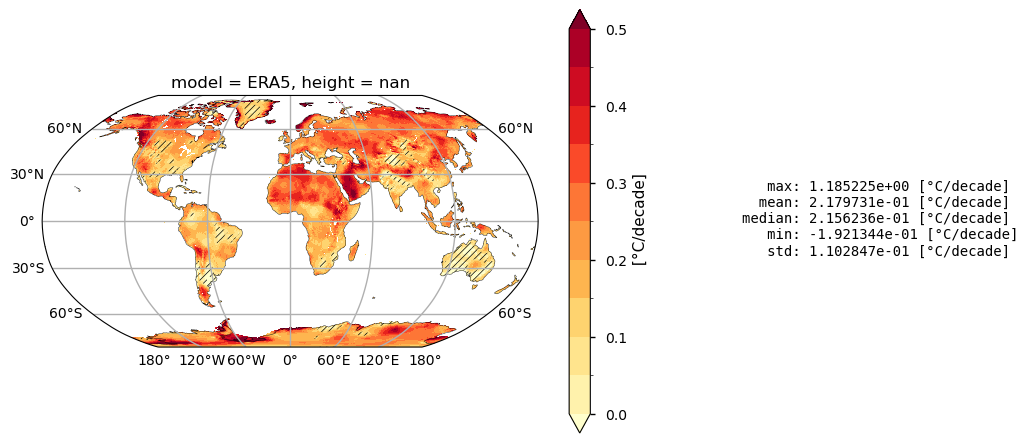

In [43]:
model = "ERA5"
m = plot.projected_map(da_trend.sel(model=model), **trend_kwargs)
plot.projected_map(
    ds_all_regr["p"].sel(model=model).drop_vars(["height", "season"], errors="ignore"),
    **p_hatches_kwargs, 
)

m.axes.gridlines(draw_labels=False)
plt.title(model)
_ = plt.suptitle(
    f"{variable.title()} trend ({year_start}-{year_stop}) - {timeseries.upper()}"
)


Fig. 3 Historical annual means trend for the ERA5 reanalysis. Hatches identify not significant trends derived by mean of Mann-Kendall test. 

## Calculate the significance of the ensemble result

For deriving trend significance for the ensemble mean we rely on agreement categories, following the advanced approach proposed in AR6 [IPCC](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Atlas.pdf), pages 1945-1950. 

The advanced approach defines three categories: No overlay indicates that the change is robust and likely emerges from internal variability (at least 66% of the models show a significant trend and at least 80% of the models agree on the sign of change); diagonal lines (\) indicate no change or no robust change (fewer than 66% of the models show a significant trend); crossed lines (X) indicate conflicting signals where at least 66% of the models show a significant trend but fewer than 80% of all models agree on the sign of change. [Atlas documentation](https://interactive-atlas.ipcc.ch/regional-information/about#robustness)

In [ ]:
#robustness of the multimodel ensemble result
is_robust = xr.where(
    (ds_sim_regr["p"] < 0.05),
    ds_sim_regr["p"]*0 + 1,
    0,
    keep_attrs=True,
)

is_robust_ratio = (is_robust.sum("model") / is_robust.sizes["model"])

is_robust_ens = xr.where(
    is_robust_ratio >= 0.66,
    is_robust_ratio*0 + 1,
    0,
    keep_attrs=True,
)

#agreement on sign in the multimodel ensemble
pos_sign = xr.where(
    ds_sim_regr["trend"] > 0,
    ds_sim_regr["trend"]+0 + 1,
    np.nan,
    keep_attrs=True,
)
neg_sign = xr.where(
    ds_sim_regr["trend"] < 0,
    ds_sim_regr["trend"]*0 - 1,
    np.nan,
    keep_attrs=True,
)

pos_sign_ratio = pos_sign.sum("model") / pos_sign.sizes["model"]
neg_sign_ratio = neg_sign.sum("model") / neg_sign.sizes["model"]

sign_agreement_ens = xr.where(
    ((pos_sign_ratio >= 0.8) | (neg_sign_ratio <= - 0.8)),
    pos_sign_ratio*0 + 1,
    0,
    keep_attrs=True,
)
sign_agreement_ens = sign_agreement_ens

#first case: Robust signal (significant change and high agreement [Colour, no overlay]
case_1 = xr.where(
    (is_robust_ens == 1) & (sign_agreement_ens == 1),
    is_robust_ens*0 + 1,
    0,
    keep_attrs=True,
)

#second case: No change or no robust signal [reverse diagnoal hatching]
case_2 = xr.where(
    (is_robust_ens == 0),
    is_robust_ens*0 + 2,
    0,
    keep_attrs=True,
)

#third case: Conflicting signals (significant change but low agreement) [crossed lines hatching]
case_3 = xr.where(
    (is_robust_ens == 1) & (sign_agreement_ens == 0),
    is_robust_ens*0 + 3,
    0,
    keep_attrs=True,
)

#the three cases are mutually exclusive, we can combine the three cases in one dataset without loosing information
ipcc_significance_cases = (case_1 + case_2 + case_3).assign_coords(model = ensemble_name)
#apply land sea mask
if mask_sea:
    ipcc_significance_cases = ipcc_significance_cases.where(da_lsm > 0.5)

## Plot esemble trends

This section plots the ensemble mean historical trend with the associated significance.

In [ ]:
plot.projected_map(
    da_trend.sel(model=ensemble_name).drop_vars(["height", "season"], errors="ignore"),
    stats_weights=weights,
    **trend_kwargs,
)
plot.projected_map(
    ipcc_significance_cases.drop_vars(["height", "season"], errors="ignore").squeeze(),
    **ipcc_significance_cases_hatches_kwargs,
)
plt.title(ensemble_name)
_ = plt.suptitle(
    f"{variable.title()} trend ({year_start}-{year_stop}) - {timeseries.upper()}"
)

Fig. 4 Historical annual CMIP6 ensemble mean trend. Uncertainty is represented with the advanced approach used in IPCC AR6. No overlay indicates regions with robust signal, where ≥66% of models show a significant trend and ≥80% of all models agree on sign of change; diagonal lines indicate regions with no change or no robust signal, where <66% of models show a significant trend; crossed lines indicate regions with conflicting signal, where ≥66% of models show a significant trend and <80% of all models agree on the sign of change. ([more info](https://www.ipcc.ch/report/ar6/wg1/chapter/atlas/#cross-chapter-box-atlas.1), under section "Displaying Robustness and Uncertainty in Maps" )

## Model-specific trends

Single model trends are derived with the Mann-Kendall test, grid point by grid point, on the model grid. This section shows the results.

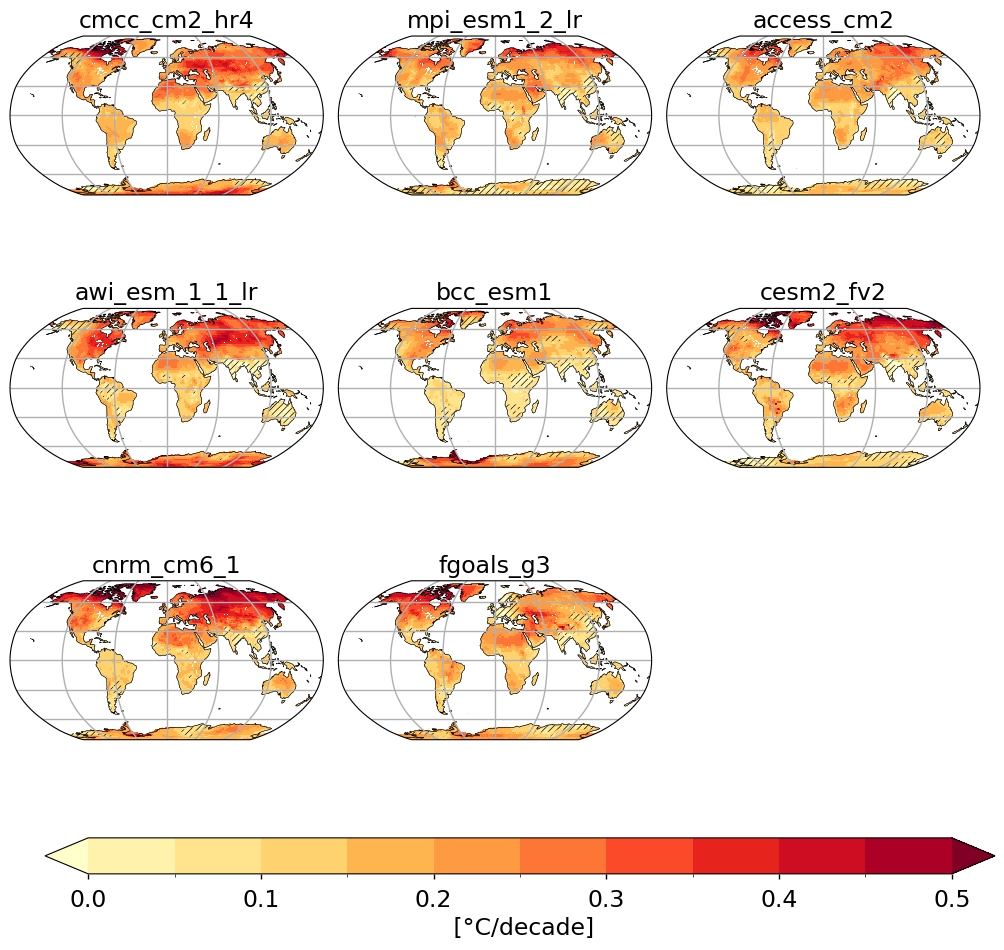

In [45]:
facet = plot.projected_map(
    da_trend.drop_sel(model=["ERA5", ensemble_name]),
    col="model",
    col_wrap=3,
    add_colorbar=False,
    **trend_kwargs,
)

i=0
for ax, sel in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
    if not sel:
        continue
    plot.projected_map(
        ds_all_regr["p"].sel(**sel).drop_vars(["height", "season"], errors="ignore"),
        ax=ax,
        **p_hatches_kwargs,
    )
    ax.set_global() if is_global else ax.set_extent(extent)
    ax.set_title(str(ds_all_regr["p"].sel(**sel).model.values),size = 17)
#plt.suptitle(
#    f"{variable.title()} trend ({year_start}-{year_stop}) - {timeseries.upper()}"
#)
cax = plt.axes(cbar_ax)
cbar = plt.colorbar(
    facet.axs[0][0].collections[0],
    cax=cax,
    orientation="horizontal",
    label=xr.plot.utils.label_from_attrs(da_trend),
)

cax.tick_params(labelsize=17)
cbar.set_label(label=xr.plot.utils.label_from_attrs(da_trend),size = 17)

Fig. 5 Model-specific trend. Hatches identify not significant trends derived by mean of Mann-Kendall test. 

## Plot trend bias for all models

This section plot the bias of the historical trend for each of the models, with respect to ERA5 trend. The field plotted here is given by the subtraction of the simulated to the reference trend in order to highlight the capability of GCMs to reproduce historical trends.

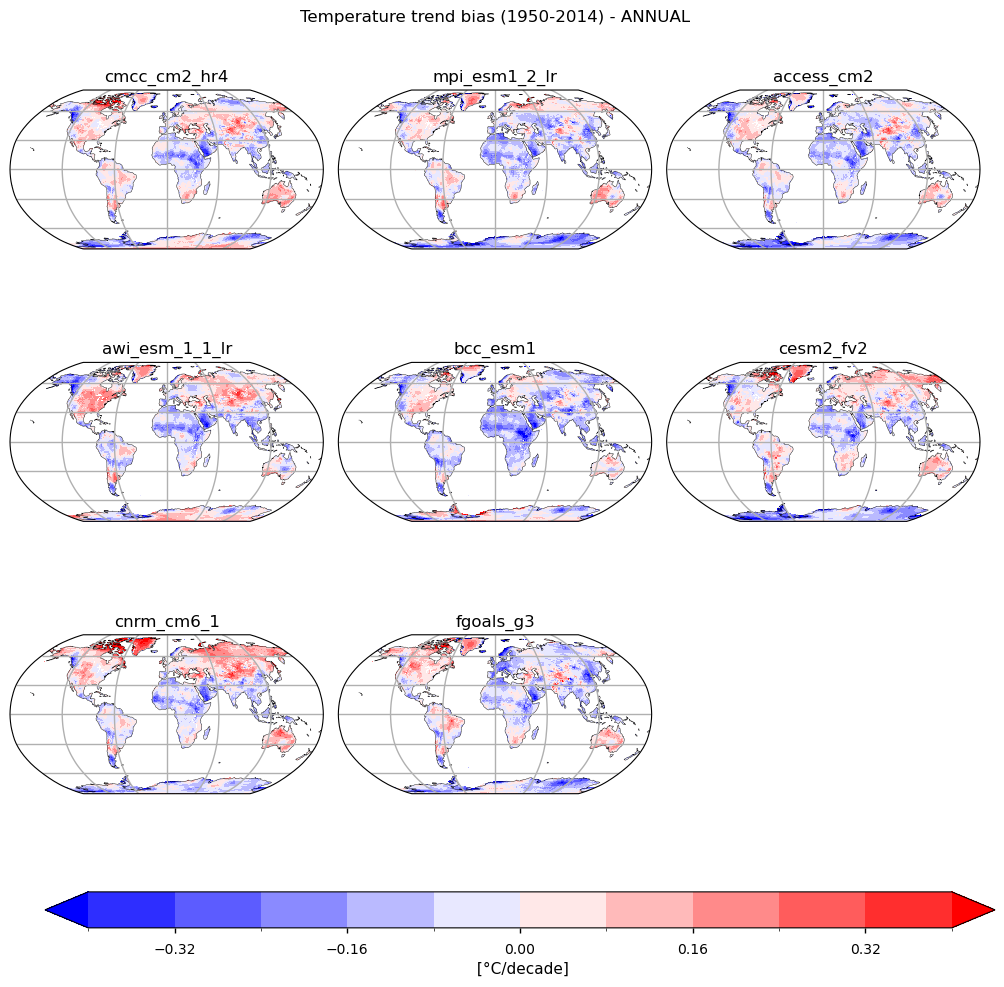

In [17]:
facet = plot.projected_map(
    da_bias.drop_sel(model=ensemble_name).drop_vars(
        ["height", "season"], errors="ignore"
    ),
    col="model",
    col_wrap=3,
    add_colorbar=False,
    **bias_kwargs,
)
for i,ax in enumerate(facet.axs.flatten()[0:len(models)]):
    ax.set_global() if is_global else ax.set_extent(extent)
    ax.set_title(str(da_bias.drop_sel(model=ensemble_name).model[i].values))
    
plt.suptitle(
    f"{variable.title()} trend bias ({year_start}-{year_stop}) - {timeseries.upper()}"
)
cax = plt.axes(cbar_ax)
_ = plt.colorbar(
    facet.axs[0][0].collections[0],
    cax=cax,
    orientation="horizontal",
    label=xr.plot.utils.label_from_attrs(da_bias),
)

Fig. 6 Model-specific trend bias 

## Ensemble mean trend bias

This section plot the bias of the historical trend of our ensemble of models, with respect to ERA5 trend.

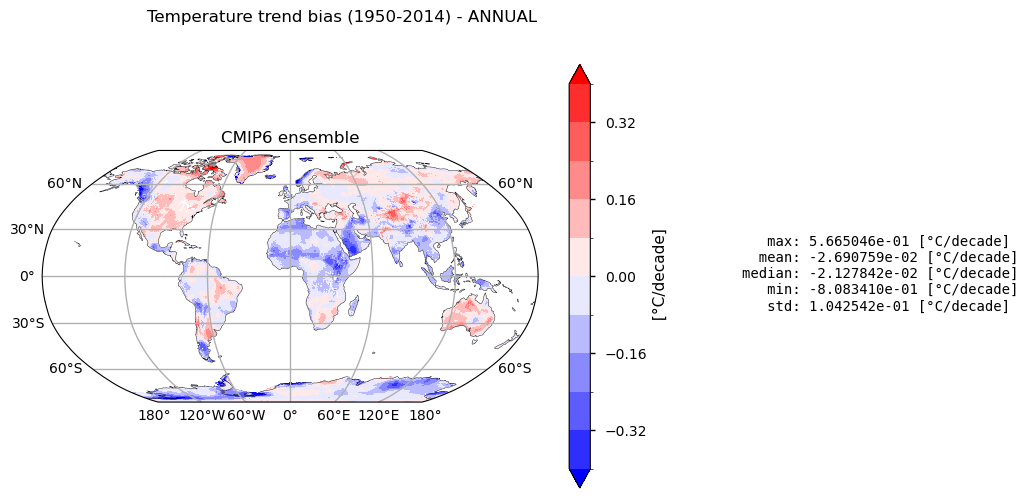

In [18]:
plot.projected_map(
    da_bias.sel(model=ensemble_name).drop_vars(["height", "season"], errors="ignore"),
    stats_weights=weights,
    **bias_kwargs,
)
plt.title(ensemble_name)
_ = plt.suptitle(
    f"{variable.title()} trend bias ({year_start}-{year_stop}) - {timeseries.upper()}"
)

Fig. 7 CMIP6 ensemble mean trend bias 

## Compute verification statistics

To assess the accuracy of models in reproducing historical trend values we compute the correlation, the root mean square error (RMSE) and the centered root mean square error (CRMSE) with respect to reference values.
These statistics, calculated using the function diagnostics.spatial_weighted_errors, appropriately consider the spatial weighting of data, as in the previous section.

The values are shown in the table below. Last column reports ensemble mean values.

In [19]:
ds_trend = da_trend.to_dataset(name="trend")
df_stats = xr.concat(
    [
        diagnostics.spatial_weighted_statistics(
            ds_trend.drop_sel(model="ERA5"), weights=weights
        ),
        diagnostics.spatial_weighted_statistics(
            ds_trend.sel(model="ERA5"), weights=True
        ),
    ],
    "model",
)["trend"].to_pandas()

df_error = diagnostics.spatial_weighted_errors(
    ds_trend.drop_sel(model="ERA5"), ds_trend.sel(model="ERA5"), weights=weights
)["trend"].to_pandas()
df_error

model,CMIP6 ensemble,cmcc_cm2_hr4,mpi_esm1_2_lr,access_cm2,awi_esm_1_1_lr,bcc_esm1,cesm2_fv2,cnrm_cm6_1,fgoals_g3
diagnostic,,,,,,,,,
corr,0.425871,0.318381,0.308323,0.282531,0.351306,0.371639,0.346222,0.398369,0.321342
crmse,0.104254,0.119211,0.115658,0.113085,0.123780,0.113141,0.124554,0.131259,0.118142
rmse,0.107671,0.119454,0.122982,0.122877,0.124541,0.131221,0.125633,0.131724,0.122450


Tab. 1 Trend statistics for each model and ensemble mean considering all the grid nodes included in the region of interest 

## Taylor Diagram

The taylor diagram, plotted in this section, aims at giving an intuitive representation of the accuracy of models data in reproducing spatial patterns. 

The [Taylor diagram](https://pcmdi.llnl.gov/staff/taylor/CV/Taylor_diagram_primer.pdf) reports spatially averaged statistics (standard deviation, spatial correlation, and centred Root Mean Square Error (CRMSE)) of individual models and corresponding ensemble mean. It provides a statistical summary of how well-simulated spatial patterns match reference data in terms of correlation, centred root-mean-square difference and variances ratio ([Taylor 2011](http://dx.doi.org/10.1029/2000JD900719)).

The three statics summarized have been applied to spatial fields of trend values (2D matrices)  and can be considered informative about the following aspects: 
- CRMSE is defined as the Root Mean Square Error between model and reference fields after the removal of the mean value of each field. It can be thought of as quantifying the capability of the models to reproduce physical values, once the mean error has been removed.
- (Spatial) Correlation. Reproducibility of the spatial pattern of the climate variable.
- Standard deviation. Reproducibility of the spatial variability of the climate variable.

PLEASE NOTE: the means of the fields are subtracted out before computing the three statistics (see [link](https://pcmdi.llnl.gov/staff/taylor/CV/Taylor_diagram_primer.pdf)), so the diagram does not provide information about overall biases, but solely characterizes the centered pattern error. 


 Taylor diagram for annual temperature trend 
 region: lon [-180, 180] x lat [-90, 90]


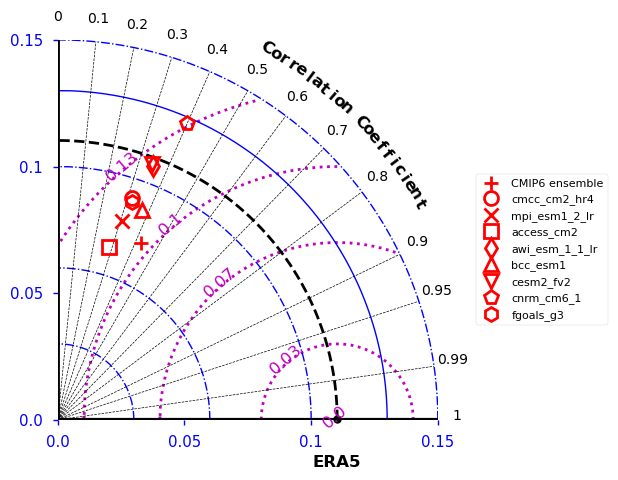

In [20]:
df_stats_and_error = pd.concat([df_stats, df_error])
df_stats_and_error = df_stats_and_error.reindex(
    columns=["ERA5", ensemble_name] + models
)
tickRMS = np.linspace(0, df_stats_and_error.loc["crmse"].max(), 5).round(2)
tickSTD = np.linspace(0, df_stats_and_error.loc["std"].max(), 5).round(2)
skill_metrics.taylor_diagram(
    df_stats_and_error.loc["std"].values,
    df_stats_and_error.loc["crmse"].values,
    df_stats_and_error.loc["corr"].values,
    alpha=0.0,
    colCOR="k",
    colOBS="k",
    colRMS="m",
    colSTD="b",
    markerColor="r" if len(df_stats_and_error.columns) >= 9 else None,  # TODO
    markerLabel=list(df_stats_and_error.columns),
    markerLegend="on",
    markerSize=10,
    markerobs="o",
    styleCOR="--",
    styleOBS="--",
    styleRMS=":",
    styleSTD="-.",
    tickRMS=tickRMS,
    tickSTD=tickSTD,
    titleCOR="on",
    titleOBS="ERA5",
    titleRMS="off",
    titleRMSDangle=40.0,
    titleSTD="off",
    widthCOR=0.5,
    widthOBS=2,
    widthRMS=2,
    widthSTD=1.0,
)

print(f' Taylor diagram for {timeseries} {variable} trend \n region: lon [{lon_slice.start}, {lon_slice.stop}] x lat [{lat_slice.start}, {lat_slice.stop}]' )

Fig. 8 [Taylor diagram](https://pcmdi.llnl.gov/staff/taylor/CV/Taylor_diagram_primer.pdf) reporting spatially averaged statistics (standard deviation, spatial correlation, and centred Root Mean Square Error) for trend maps of individual models and corresponding ensemble mean. Blue semicircles are  isolines of standard deviation of the fields. Purple semicircles are isolines of CRMSE with respect to ERA5.

## Main results

Despite consistent bias in capturing the global mean 2m air temperature (figure 1a) GCMs are optimal tools for reproducing historical (1950-2014) global warming trend (figure 1b). The ensemble mean warming trend of our small set of models (0.20 °C per decade) closely match the reference ERA5 one (0.22 °C per decade). Trend values in the ensemble range approximately between 0.15 and 0.23 °C.

Even if the global mean trend is well captured by the ensemble, consistent are the bias considering the spatial distribution(figure 8). Noticeable, an extended cold bias over Africa, shared by all the models of the ensemble (figure 7).
Northern hemisphere amplification of the warming signal is well captured by the ensemble mean.

In the context of global temperature trend analysis, the Taylor diagram shows:

- a scarse capability by models to reproduce the observed spatial patterns (spatial correlation about 0.4)
- Some scatter among GCMs in reproducing precipitation spatial variability. For instance, we can observe the cnrm_cm6_1 model overestimating the spatial variability of the reference data (ERA5) conversely to other models, that tend to underestimate it.
- In terms of RMSE and CRMSE the ensemble mean is the most accurate product in this case, performing better than the single models.




## Final remarks

As for the climatology assessment we advocate considering also season-specific analyses and maximum as much as possible the ensemble size to better include the uncertainty given by inter-model variability. This is especially relevant also in the case of precipitation trends, which represents a more difficult task compared to the temperature.

Nevertheless, we do not advocate for direct use of GCM outputs if regional-to-local scale information is sought (e.g., driving hydrological, agricultural, or wind power modelling tools) or changes in extremes (wind storms or heatwaves) at such fine scales.